In [3]:
!pip install rdkit -q
!pip install torch_geometric -q
!pip install e3nn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.1/450.1 kB 10.2 MB/s eta 0:00:00


In [4]:
# @title
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTHONHASHSEED"] = "42"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import random
import numpy as np
import torch
import tensorflow as tf

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    tf.random.set_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [5]:
data_size = 10000
USE_QM = False

In [ ]:
# @title
import matplotlib.pyplot as plt
import numpy as np
#used seperately later
def plot_parity_and_hist(y_true, y_pred, title, filename, data_size=data_size):

    errors = y_pred - y_true
    full_title = title + f" (data size = {data_size})"
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))


    ax = axes[0]
    ax.scatter(y_true, y_pred, s=10, alpha=0.5)

    mn = min(y_true.min(), y_pred.min())
    mx = max(y_true.max(), y_pred.max())
    ax.plot([mn, mx], [mn, mx], linestyle="--", linewidth=2)
    ax.set_xlabel("True PBE0 gap (eV)")
    ax.set_ylabel("Predicted PBE0 gap (eV)")
    ax.set_title("Parity Plot")
    ax.grid(True)

    ax = axes[1]
    ax.hist(errors, bins=40, alpha=0.7, edgecolor='black')

    ax.set_xlabel("Prediction Error (eV)")
    ax.set_ylabel("Count")
    ax.set_title("Error Histogram")
    ax.grid(True)


    plt.suptitle(full_title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename, dpi=300)
    plt.show()

    print(f"Saved combined plot: {filename}")


In [12]:
# @title
import os, sys, argparse, pickle
from tqdm import tqdm
import numpy as np
import tensorflow_datasets as tfds
import torch
from torch_geometric.data import Data
import random

HA2EV = 27.211386245988

def frontier_gap_from_orbitals(ener_a, occ_a, ener_b=None, occ_b=None, thr=0.5):
    """
    Given orbital energies and occupations for alpha/beta (or single channel),
    compute HOMO & LUMO frontier energies and gap in eV.
    ener_a, occ_a, ener_b, occ_b can be numpy arrays or None.
    Uses rule in assignment: HOMO = highest index with occ > 0.5, LUMO = lowest with occ <= 0.5.
    Returns gap in eV (float). If impossible, returns np.nan.
    """
    try:
        e_a = np.array(ener_a)
        o_a = np.array(occ_a)
    except Exception:
        return np.nan

    def homo_lumo(e, o):

        occ_idx = np.where(o > thr)[0]
        unocc_idx = np.where(o <= thr)[0]
        homo_e = e[occ_idx.max()] if occ_idx.size else -np.inf
        lumo_e = e[unocc_idx.min()] if unocc_idx.size else np.inf
        return homo_e, lumo_e

    ha, la = homo_lumo(e_a, o_a)
    if ener_b is not None and occ_b is not None:
        e_b = np.array(ener_b); o_b = np.array(occ_b)
        hb, lb = homo_lumo(e_b, o_b)
    else:
        hb, lb = -np.inf, np.inf

    # gap in Hartree
    gap_hartree = min(la, lb) - max(ha, hb)
    if not np.isfinite(gap_hartree):
        return np.nan
    return float(gap_hartree * HA2EV)


def gap_from_energies(energies):
    e = np.array(energies)
    if e.size == 0:
        return np.nan

    e_sorted = np.sort(e)

    gap = e_sorted[0] - e_sorted[-1]
    return float(gap * HA2EV)

def build_graph_from_example(ex, bond_order_cutoff=0.05, use_qm=False):  # 🔥 ADDED use_qm
    atomic_numbers = ex["atomic_numbers"]
    positions = ex["positions"]
    n = len(atomic_numbers)
    if n == 0:
        return None

    # ------------------------------
    # compute gaps (same as before)
    # ------------------------------
    gfn2_gap = np.nan
    pbe0_gap = np.nan

    if ("gfn2_orbital_energies_a" in ex) and ("gfn2_orbital_occupations_a" in ex):
        try:
            gfn2_gap = frontier_gap_from_orbitals(
                ex["gfn2_orbital_energies_a"], ex["gfn2_orbital_occupations_a"],
                ex.get("gfn2_orbital_energies_b", None), ex.get("gfn2_orbital_occupations_b", None)
            )
        except Exception:
            gfn2_gap = np.nan
    if np.isnan(gfn2_gap) and ("gfn2_orbital_energies_a" in ex):
        try:
            gfn2_gap = gap_from_energies(ex["gfn2_orbital_energies_a"])
        except Exception:
            gfn2_gap = np.nan

    if ("pbe0_orbital_energies_a" in ex) and ("pbe0_orbital_occupations_a" in ex):
        try:
            pbe0_gap = frontier_gap_from_orbitals(
                ex["pbe0_orbital_energies_a"], ex["pbe0_orbital_occupations_a"],
                ex.get("pbe0_orbital_energies_b", None), ex.get("pbe0_orbital_occupations_b", None)
            )
        except Exception:
            pbe0_gap = np.nan

    # simulate PBE0 if missing
    if np.isnan(pbe0_gap):
        if np.isnan(gfn2_gap):
            return None
        heavy_count = int(ex.get("num_heavy_atoms", np.sum(np.array(atomic_numbers)!=1)))
        seed_val = 0
        if "key_hash" in ex:
            seed_val = int.from_bytes(ex["key_hash"][:4], "little", signed=False) % (2**31)
        rng = np.random.RandomState(seed=seed_val)
        noise = float(rng.normal(0, 0.01))
        pbe0_gap = float(gfn2_gap + 0.02 * heavy_count + noise)

    if np.isnan(gfn2_gap):
        return None

    delta = float(pbe0_gap - gfn2_gap)

    # ------------------------------
    # edges (same as before)
    # ------------------------------
    wbo = ex.get("gfn2_wiberg_bond_orders", None)
    edge_src = []
    edge_dst = []
    edge_attrs = []

    if wbo is not None and isinstance(wbo, np.ndarray) and wbo.size > 0:
        for i in range(n):
            for j in range(i+1, n):
                bo = float(wbo[i, j])
                if bo > bond_order_cutoff:
                    dist = float(np.linalg.norm(positions[i] - positions[j]))
                    edge_src.extend([i,j]); edge_dst.extend([j,i])
                    edge_attrs.append([dist, bo]); edge_attrs.append([dist, bo])
    else:
        for i in range(n):
            for j in range(i+1, n):
                dist = float(np.linalg.norm(positions[i] - positions[j]))
                if dist < 1.8:
                    edge_src.extend([i,j]); edge_dst.extend([j,i])
                    edge_attrs.append([dist, 0.0]); edge_attrs.append([dist, 0.0])

    if len(edge_src) == 0:
        for i in range(n):
            for j in range(i+1, n):
                dist = float(np.linalg.norm(positions[i] - positions[j]))
                edge_src.extend([i,j]); edge_dst.extend([j,i])
                edge_attrs.append([dist, 0.0]); edge_attrs.append([dist, 0.0])

    # ------------------------------
    # Build Data object
    # ------------------------------
    edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float32)

    x = torch.tensor(atomic_numbers, dtype=torch.long).view(-1,1)
    pos = torch.tensor(positions, dtype=torch.float32)
    y = torch.tensor([delta], dtype=torch.float32)
    gfn2_gap_t = torch.tensor([gfn2_gap], dtype=torch.float32)
    pbe0_gap_t = torch.tensor([pbe0_gap], dtype=torch.float32)

    data = Data(
        x=x,
        pos=pos,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        gfn2_gap=gfn2_gap_t,
        pbe0_gap=pbe0_gap_t
    )
    if use_qm:
        if "charge" in ex and "multiplicity" in ex:
            Q = float(ex["charge"])
            M = float(ex["multiplicity"])
        else:
            Q = 0.0
            M = 1.0  # default
        data.Q = torch.tensor([Q], dtype=torch.float32)
        data.M = torch.tensor([M], dtype=torch.float32)

    return data


# ------------------------------
# MAIN
# ------------------------------
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--dataset", default="qcml/xtb_all:1.0.0")
    parser.add_argument("--gcs_dir", default="gs://qcml-datasets/tfds/")
    parser.add_argument("--n", type=int, default=data_size)
    parser.add_argument("--out", default="graphs.pkl")
    parser.add_argument("--seed", type=int, default=42)

    parser.add_argument("--use_qm", action="store_true",
                        help="include Q (charge) and M (multiplicity) in graph")

    args, unknown = parser.parse_known_args()

    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    print("Loading dataset...")
    ds = tfds.load(args.dataset, split=f"full[:{args.n}]", shuffle_files=False,
                   as_supervised=False, data_dir=args.gcs_dir)

    graphs = []
    skipped = 0

    for ex in tqdm(tfds.as_numpy(ds), total=args.n, desc="Building graphs"):
        try:
            g = build_graph_from_example(ex, use_qm=args.use_qm)   # 🔥 add flag
            if g is None:
                skipped += 1
                continue
            graphs.append(g)
        except Exception:
            skipped += 1
            continue

    print(f"Built {len(graphs)} graphs, skipped {skipped}. Saving to {args.out}")
    with open(args.out, "wb") as f:
        pickle.dump(graphs, f)

if __name__ == "__main__":
    main()


Loading dataset...


Building graphs: 100%|██████████| 10000/10000 [00:22<00:00, 442.68it/s]


Built 10000 graphs, skipped 0. Saving to graphs.pkl


Loaded graphs (raw): 10000
After filtering: 10000 valid graphs, skipped 0 invalid/outlier graphs
Train: 8000, Val: 1000, Test: 1000

===== TASK A: GFN2 BASELINE (fixed) =====
Valid test graphs used = 1000 (missing/invalid in test: 0)
GFN2 → PBE0  |  TEST MAE = 0.1464 eV
GFN2 → PBE0  |  TEST R²  = 0.9918



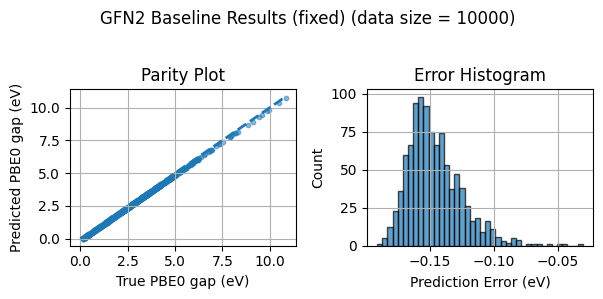

Saved combined plot: GFN2_Baseline_fixed_combined_plot.png
Saved: taskA_results.txt
Saved: GFN2_Baseline_fixed_combined_plot.png


In [13]:
"""A. Baseline: Compute and report the naïve GFN2 gap (no learning).
Fixed version: safer filtering, skip outliers, robust conversions, and
correct handling of missing values before computing baseline metrics.
Keep style and readability consistent with the rest of your notebook.
"""

import pickle
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch


# -------------------------------
# Load graphs.pkl
# -------------------------------
with open("graphs.pkl", "rb") as f:
    graphs = pickle.load(f)

print("Loaded graphs (raw):", len(graphs))

# -------------------------------
# Filter graphs: require finite gfn2_gap and pbe0_gap
# also skip graphs marked as outliers (if attribute present)
# -------------------------------
def is_valid_graph(g):
    # skip if outlier flag present
    if getattr(g, "is_outlier", False):
        return False
    # check attributes exist
    if not hasattr(g, "gfn2_gap") or not hasattr(g, "pbe0_gap"):
        return False
    try:
        g_gfn2 = float(g.gfn2_gap.item()) if torch.is_tensor(g.gfn2_gap) else float(g.gfn2_gap)
        g_pbe0 = float(g.pbe0_gap.item()) if torch.is_tensor(g.pbe0_gap) else float(g.pbe0_gap)
    except Exception:
        return False
    # require finite numeric values
    if not np.isfinite(g_gfn2) or not np.isfinite(g_pbe0):
        return False
    return True

valid_graphs = [g for g in graphs if is_valid_graph(g)]
skipped = len(graphs) - len(valid_graphs)
print(f"After filtering: {len(valid_graphs)} valid graphs, skipped {skipped} invalid/outlier graphs")

if len(valid_graphs) == 0:
    raise RuntimeError("No valid graphs found for Task A baseline after filtering. Check graphs.pkl or graph builder.")

# -------------------------------
# Split into train / val / test
# (same split used in rest of pipeline)
# -------------------------------
SEED = 42
train_graphs, temp_graphs = train_test_split(valid_graphs, test_size=0.2, random_state=SEED)
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=SEED)

print(f"Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")

# -------------------------------
# Task A: Compute GFN2 baseline (only on test set)
# -------------------------------
def tensor_or_number_to_float(x):
    # helper to convert tensor or number to python float
    if torch.is_tensor(x):
        return float(x.item())
    else:
        return float(x)

gfn2_pred_list = []
pbe0_true_list = []
missing = 0

for g in test_graphs:
    try:
        g_gfn2 = tensor_or_number_to_float(g.gfn2_gap)
        g_pbe0 = tensor_or_number_to_float(g.pbe0_gap)
    except Exception:
        missing += 1
        continue
    # guard again for finiteness
    if not (np.isfinite(g_gfn2) and np.isfinite(g_pbe0)):
        missing += 1
        continue
    gfn2_pred_list.append(g_gfn2)
    pbe0_true_list.append(g_pbe0)

if len(gfn2_pred_list) == 0:
    raise RuntimeError("No usable test graphs for baseline after final filtering.")

gfn2_pred = np.array(gfn2_pred_list)
pbe0_true = np.array(pbe0_true_list)

mae_gfn2 = mean_absolute_error(pbe0_true, gfn2_pred)
r2_gfn2 = r2_score(pbe0_true, gfn2_pred)

print("\n===== TASK A: GFN2 BASELINE (fixed) =====")
print(f"Valid test graphs used = {len(gfn2_pred)} (missing/invalid in test: {missing})")
print(f"GFN2 → PBE0  |  TEST MAE = {mae_gfn2:.4f} eV")
print(f"GFN2 → PBE0  |  TEST R²  = {r2_gfn2:.4f}")
print("=========================================\n")

# Save metrics
with open("taskA_results.txt", "w") as f:
    f.write(f"GFN2 Baseline MAE: {mae_gfn2:.4f} eV\n")
    f.write(f"GFN2 Baseline R2:  {r2_gfn2:.4f}\n")
    f.write(f"Valid test graphs: {len(gfn2_pred)}\n")
    f.write(f"Skipped/invalid graphs (total): {skipped}\n")

# Plot parity + error histogram using your plotting helper
plot_parity_and_hist(pbe0_true, gfn2_pred, "GFN2 Baseline Results (fixed)", "GFN2_Baseline_fixed_combined_plot.png", data_size=len(valid_graphs))

print("Saved: taskA_results.txt")
print("Saved: GFN2_Baseline_fixed_combined_plot.png")

Loaded graphs (raw): 10000
After filtering: 10000 graphs, skipped 0 invalid/outlier graphs
Train: 8000, Val: 1000, Test: 1000
use_qm_in_model = False
Training simple E(3)-equivariant GNN...
Epoch 1  Loss=0.859082  Val MAE=1.183217
  → New best model saved (epoch 1)  val_mae=1.183217
Epoch 2  Loss=0.778616  Val MAE=1.085469
  → New best model saved (epoch 2)  val_mae=1.085469
Epoch 3  Loss=0.755853  Val MAE=1.079128
  → New best model saved (epoch 3)  val_mae=1.079128
Epoch 4  Loss=0.736354  Val MAE=1.087232
Epoch 5  Loss=0.727769  Val MAE=1.073739
  → New best model saved (epoch 5)  val_mae=1.073739
Epoch 6  Loss=0.713920  Val MAE=1.066170
  → New best model saved (epoch 6)  val_mae=1.066170
Epoch 7  Loss=0.698410  Val MAE=1.030544
  → New best model saved (epoch 7)  val_mae=1.030544
Epoch 8  Loss=0.684902  Val MAE=1.035276
Epoch 9  Loss=0.694174  Val MAE=1.031349
Epoch 10  Loss=0.699833  Val MAE=1.049055
Epoch 11  Loss=0.681362  Val MAE=1.049915
Epoch 12  Loss=0.667113  Val MAE=1.0090

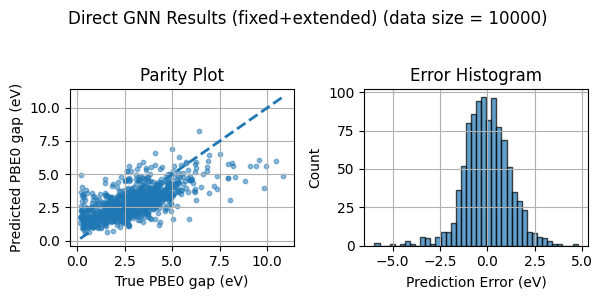

Saved combined plot: Direct_GNN_fixed_combined_plot.png
Saved: taskB_results.txt
Saved: Direct_GNN_fixed_combined_plot.png


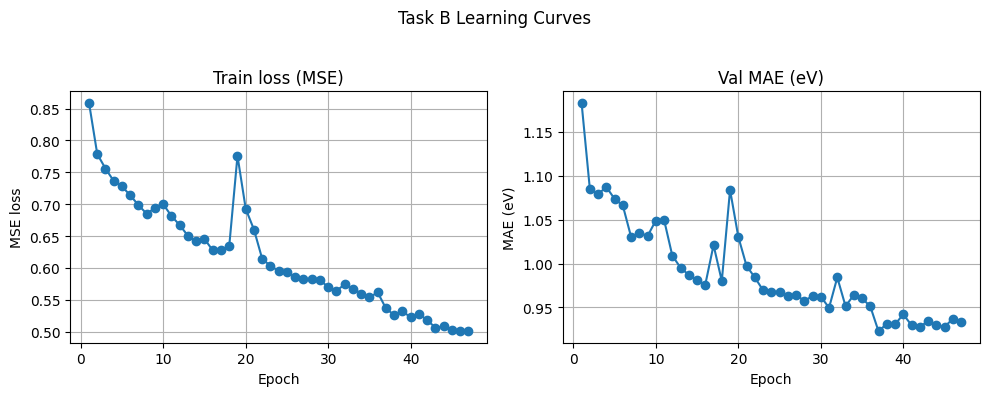

Saved: taskB_learning_curve.png


In [16]:
""" B. Model 1 (Direct): Train an E(3)/SE(3)-equivariant
Fixed + extended version:
- safe filtering, skip outliers
- correct target scaling (dedicated pbe0_scaler)
- use Q/M when present (optional via flag)
- early stopping + best-checkpoint saving
- LR scheduler (ReduceLROnPlateau) (Colab-compatible)
- CSV logging of train/val per-epoch metrics
- saved scaler to disk
- learning-curve plotting
Keep style consistent with original notebook.
"""

import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import random
import joblib

class ContinuousFilterConv(nn.Module):
    """Simple SchNet interaction block (E(3)-equivariant)"""
    def __init__(self, hidden_dim):
        super().__init__()
        self.filter_net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.dense = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x, pos, edge_index):
        # edge_index expected as [2, E]
        src, dst = edge_index
        # distances (equivariant input)
        dist = torch.norm(pos[dst] - pos[src], dim=-1, keepdim=True)  # [E,1]
        # filter weights
        w = self.filter_net(dist)  # [E, hidden]
        # message passing
        m = x[src] * w  # filter messages  (broadcasting)
        out = torch.zeros_like(x)
        out.index_add_(0, dst, m)
        return self.dense(out)


class SimpleEquivariantGNN(nn.Module):
    """
    TASK B model:
    - Uses only distances → E(3)-equivariant
    - Predicts PBE0 gap directly (scaled)
    - Optionally uses Q and M (charge & multiplicity) if present in Data
    """
    def __init__(self, hidden_dim=64, num_layers=3, use_qm=False):
        super().__init__()
        self.emb = nn.Embedding(100, hidden_dim)
        self.use_qm = use_qm

        self.layers = nn.ModuleList([
            ContinuousFilterConv(hidden_dim) for _ in range(num_layers)
        ])

        fc_in = hidden_dim + (2 if self.use_qm else 0)
        self.fc = nn.Sequential(
            nn.Linear(fc_in, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, data):
        x = self.emb(data.x.squeeze(-1).long())
        pos = data.pos
        edge_index = data.edge_index

        for layer in self.layers:
            x = x + layer(x, pos, edge_index)  # residual update

        g = global_mean_pool(x, data.batch)

        if self.use_qm:
            # ensure Q and M exist as tensors (fallback to zeros)
            device = g.device
            if hasattr(data, "Q") and hasattr(data, "M"):
                qm = torch.cat([data.Q.view(-1,1).to(device), data.M.view(-1,1).to(device)], dim=1)
            else:
                qm = torch.zeros((g.size(0), 2), device=device)
            g = torch.cat([g, qm], dim=1)

        return self.fc(g).view(-1)



def tensor_or_number_to_float(x):
    if torch.is_tensor(x):
        return float(x.item())
    else:
        return float(x)


with open("graphs.pkl", "rb") as f:
    graphs = pickle.load(f)

print("Loaded graphs (raw):", len(graphs))

def is_valid_graph_for_direct(g):

    if getattr(g, "is_outlier", False):
        return False
    if not hasattr(g, "pbe0_gap"):
        return False
    if not hasattr(g, "gfn2_gap"):
        return False
    try:
        p = tensor_or_number_to_float(g.pbe0_gap)
        q = tensor_or_number_to_float(g.gfn2_gap)
    except Exception:
        return False
    if not (np.isfinite(p) and np.isfinite(q)):
        return False
    return True

filtered_graphs = [g for g in graphs if is_valid_graph_for_direct(g)]
skipped = len(graphs) - len(filtered_graphs)
print(f"After filtering: {len(filtered_graphs)} graphs, skipped {skipped} invalid/outlier graphs")

if len(filtered_graphs) == 0:
    raise RuntimeError("No valid graphs found for Task B after filtering. Check graphs.pkl or graph builder.")


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

train_graphs, temp_graphs = train_test_split(filtered_graphs, test_size=0.2, random_state=SEED)
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=SEED)

print(f"Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")


pbe0_vals = np.array([[tensor_or_number_to_float(g.pbe0_gap)] for g in train_graphs])
pbe0_scaler = StandardScaler().fit(pbe0_vals)

def set_pbe0_scaled(graphs_list, scaler):
    for g in graphs_list:
        val = tensor_or_number_to_float(g.pbe0_gap)
        g.pbe0_scaled = torch.tensor(scaler.transform([[val]])[0,0], dtype=torch.float32)

set_pbe0_scaled(train_graphs, pbe0_scaler)
set_pbe0_scaled(val_graphs, pbe0_scaler)
set_pbe0_scaled(test_graphs, pbe0_scaler)


os.makedirs("scalers", exist_ok=True)
joblib.dump(pbe0_scaler, "scalers/pbe0_scaler.joblib")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_qm_in_model = any(hasattr(g, "Q") and hasattr(g, "M") for g in filtered_graphs)
print("use_qm_in_model =", use_qm_in_model)

model = SimpleEquivariantGNN(use_qm=use_qm_in_model).to(device)

train_loader = DataLoader(train_graphs, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=64)
test_loader  = DataLoader(test_graphs,  batch_size=64)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
loss_fn = nn.MSELoss()


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=4
)

patience = 10
best_val_mae = float("inf")
patience_counter = 0
best_epoch = 0

os.makedirs("logs", exist_ok=True)
csv_path = "logs/taskB_training_log.csv"
with open(csv_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["epoch", "train_loss", "val_mae"])

print("Training simple E(3)-equivariant GNN...")

NUM_EPOCHS = 100
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_losses = []

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        pred = model(batch)
        target = batch.pbe0_scaled.to(device)

        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            p_scaled = model(batch).cpu().numpy().reshape(-1,1)
            p = pbe0_scaler.inverse_transform(p_scaled).reshape(-1)
            t = batch.pbe0_gap.cpu().numpy().ravel()
            preds.append(p); trues.append(t)

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    val_mae = mean_absolute_error(trues, preds)


    scheduler.step(val_mae)


    with open(csv_path, "a", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([epoch, np.mean(train_losses), val_mae])

    print(f"Epoch {epoch}  Loss={np.mean(train_losses):.6f}  Val MAE={val_mae:.6f}")

    # early stopping & checkpoint best
    if val_mae < best_val_mae - 1e-8:
        best_val_mae = val_mae
        patience_counter = 0
        best_epoch = epoch
        torch.save(model.state_dict(), "taskB_best_model.pt")
        print(f"  → New best model saved (epoch {epoch})  val_mae={val_mae:.6f}")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered (patience {patience}) at epoch {epoch}. Best epoch = {best_epoch}, best_val_mae = {best_val_mae:.6f}")
        break


torch.save(model.state_dict(), "taskB_equivariant_model_final.pt")
print("Saved final model → taskB_equivariant_model_final.pt")


if os.path.exists("taskB_best_model.pt"):
    model.load_state_dict(torch.load("taskB_best_model.pt", map_location=device))
    print("Loaded best model from taskB_best_model.pt for final evaluation.")

model.eval()
preds, trues = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        p_scaled = model(batch).cpu().numpy().reshape(-1,1)
        p = pbe0_scaler.inverse_transform(p_scaled).reshape(-1)
        t = batch.pbe0_gap.cpu().numpy().ravel()
        preds.append(p); trues.append(t)

preds = np.concatenate(preds)
trues = np.concatenate(trues)

mae_test = mean_absolute_error(trues, preds)
r2_test  = r2_score(trues, preds)

print("\n====== TASK B RESULTS (Equivariant GNN) ======")
print(f"TEST MAE = {mae_test:.4f} eV")
print(f"TEST R2  = {r2_test:.4f}")
print("==============================================")


with open("taskB_results.txt", "w") as f:
    f.write(f"TEST MAE: {mae_test:.4f} eV\n")
    f.write(f"TEST R2:  {r2_test:.4f}\n")
    f.write(f"Used graphs (train/val/test): {len(train_graphs)}/{len(val_graphs)}/{len(test_graphs)}\n")
    f.write(f"Skipped graphs during filtering: {skipped}\n")
    f.write(f"Best epoch (val): {best_epoch}\n")


plot_parity_and_hist(trues, preds, "Direct GNN Results (fixed+extended)", "Direct_GNN_fixed_combined_plot.png", data_size=len(filtered_graphs))
print("Saved: taskB_results.txt")
print("Saved: Direct_GNN_fixed_combined_plot.png")

# ----------------------------------------
# Plot learning curve (train/val) from CSV
# ----------------------------------------
epochs, train_losses, val_maes = [], [], []
with open(csv_path, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        epochs.append(int(row["epoch"]))
        train_losses.append(float(row["train_loss"]))
        val_maes.append(float(row["val_mae"]))

# simple two-panel plot: train loss (scaled MSE) and val MAE (eV)
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(epochs, train_losses, marker='o')
axes[0].set_title("Train loss (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE loss")
axes[0].grid(True)

axes[1].plot(epochs, val_maes, marker='o')
axes[1].set_title("Val MAE (eV)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MAE (eV)")
axes[1].grid(True)

plt.suptitle("Task B Learning Curves")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("taskB_learning_curve.png", dpi=300)
plt.show()
print("Saved: taskB_learning_curve.png")

Loaded graphs (raw): 10000
After filtering: 10000 graphs, skipped 0 invalid/outlier graphs
Train: 8000, Val: 1000, Test: 1000
use_qm_in_model = False
Training Δ-learning model...
Epoch 1 | Train Loss = 0.931507 | Val MAE = 0.015778
  → New best model saved (epoch 1)  val_mae=0.015778
Epoch 2 | Train Loss = 0.880275 | Val MAE = 0.015816
Epoch 3 | Train Loss = 0.840579 | Val MAE = 0.015155
  → New best model saved (epoch 3)  val_mae=0.015155
Epoch 4 | Train Loss = 0.814853 | Val MAE = 0.015187
Epoch 5 | Train Loss = 0.795364 | Val MAE = 0.015080
  → New best model saved (epoch 5)  val_mae=0.015080
Epoch 6 | Train Loss = 0.779405 | Val MAE = 0.014797
  → New best model saved (epoch 6)  val_mae=0.014797
Epoch 7 | Train Loss = 0.765631 | Val MAE = 0.014654
  → New best model saved (epoch 7)  val_mae=0.014654
Epoch 8 | Train Loss = 0.749812 | Val MAE = 0.014838
Epoch 9 | Train Loss = 0.731546 | Val MAE = 0.014255
  → New best model saved (epoch 9)  val_mae=0.014255
Epoch 10 | Train Loss = 0.

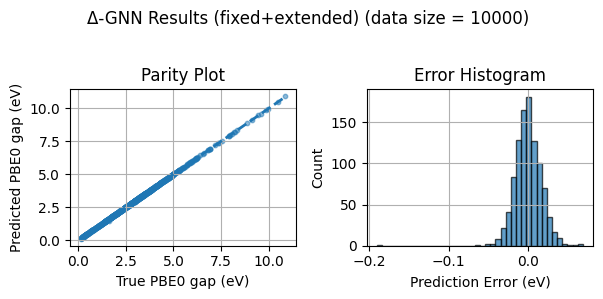

Saved combined plot: DeltaGNN_fixed_combined_plot.png
Saved: taskC_results.txt
Saved: DeltaGNN_fixed_combined_plot.png


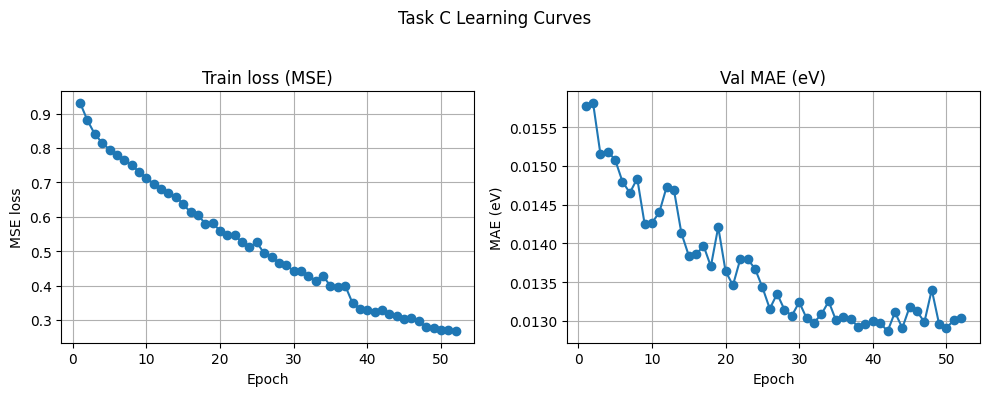

Saved: taskC_learning_curve.png


In [17]:
""" C. Model 2 (∆-learning): Compute the GFN2 gap; train a GNN to predict
Δ_gap = PBE0_gap − GFN2_gap, and output gap_pred = gfn2 + Δ_pred.

Fixed + extended version:
- robust filtering (skip outliers / missing fields)
- separate scalers: edge_attr_scaler, delta_scaler, gfn2_scaler
- safe handling when some graphs have empty edge_attr
- correct scaling for gfn2 used as model input (g.gfn2_gap_scaled)
- model optionally uses Q/M (charge & multiplicity) when present
- early stopping + LR scheduler + best-checkpoint saving
- CSV logging and learning-curve plotting
- save scalers to disk
Style kept consistent with your notebook.
"""

import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, MessagePassing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import random
import joblib


class SimpleMPNN(MessagePassing):
    def __init__(self, hidden=64):
        # sum aggregation
        super().__init__(aggr='add')
        # message takes x_i, x_j and edge_attr (we'll concat)
        # edge_attr expected to be sized [E, edge_dim]
        # we'll assume node embed dim == hidden
        self.lin_msg = nn.Linear(hidden * 2 + 2, hidden)
        self.lin_upd = nn.Linear(hidden + hidden, hidden)

    def forward(self, x, edge_index, edge_attr):

        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):

        m = torch.cat([x_i, x_j, edge_attr], dim=1)
        return F.relu(self.lin_msg(m))

    def update(self, aggr_out, x):
        h = torch.cat([x, aggr_out], dim=1)
        return F.relu(self.lin_upd(h))


class DeltaGNN(nn.Module):

    def __init__(self, hidden=64, use_qm=False):
        super().__init__()
        self.embed = nn.Embedding(100, hidden)
        self.mpnn1 = SimpleMPNN(hidden)
        self.mpnn2 = SimpleMPNN(hidden)
        self.use_qm = use_qm

        readin = hidden + 1 + (2 if self.use_qm else 0)
        self.readout = nn.Sequential(
            nn.Linear(readin, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, data):
        x = self.embed(data.x.squeeze(-1).long())


        edge_attr = data.edge_attr
        x = self.mpnn1(x, data.edge_index, edge_attr)
        x = self.mpnn2(x, data.edge_index, edge_attr)

        g = global_mean_pool(x, data.batch)


        if hasattr(data, "gfn2_gap_scaled"):
            gfn2 = data.gfn2_gap_scaled.view(-1, 1).to(g.device)
        else:

            gfn2 = torch.zeros((g.size(0), 1), device=g.device)

        if self.use_qm:
            device = g.device
            if hasattr(data, "Q") and hasattr(data, "M"):
                qm = torch.cat([data.Q.view(-1,1).to(device), data.M.view(-1,1).to(device)], dim=1)
            else:
                qm = torch.zeros((g.size(0), 2), device=device)
            g = torch.cat([g, gfn2, qm], dim=1)
        else:
            g = torch.cat([g, gfn2], dim=1)

        return self.readout(g).view(-1)


def tensor_or_number_to_float(x):
    if torch.is_tensor(x):
        return float(x.item())
    else:
        return float(x)


with open("graphs.pkl", "rb") as f:
    graphs = pickle.load(f)

print("Loaded graphs (raw):", len(graphs))

def is_valid_graph_for_delta(g):

    if getattr(g, "is_outlier", False):
        return False
    if not hasattr(g, "gfn2_gap") or not hasattr(g, "pbe0_gap"):
        return False
    try:
        gfn2 = tensor_or_number_to_float(g.gfn2_gap)
        pbe0 = tensor_or_number_to_float(g.pbe0_gap)
    except Exception:
        return False
    if not (np.isfinite(gfn2) and np.isfinite(pbe0)):
        return False

    return True

filtered_graphs = [g for g in graphs if is_valid_graph_for_delta(g)]
skipped = len(graphs) - len(filtered_graphs)
print(f"After filtering: {len(filtered_graphs)} graphs, skipped {skipped} invalid/outlier graphs")

if len(filtered_graphs) == 0:
    raise RuntimeError("No valid graphs found for Task C after filtering. Check graphs.pkl or graph builder.")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

train_graphs, temp_graphs = train_test_split(filtered_graphs, test_size=0.2, random_state=SEED)
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=SEED)

print(f"Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")


edge_list = []
for g in train_graphs:
    if hasattr(g, "edge_attr") and g.edge_attr is not None and g.edge_attr.numel() > 0:

        edge_list.append(g.edge_attr.numpy())
if len(edge_list) > 0:
    edge_data = np.vstack(edge_list)
    edge_scaler = StandardScaler().fit(edge_data)
else:

    edge_scaler = None
    print("Warning: No edge attributes found in training set. Message passing will still run but edge scaling skipped.")


delta_vals = np.array([[tensor_or_number_to_float(g.pbe0_gap) - tensor_or_number_to_float(g.gfn2_gap)] for g in train_graphs])
delta_scaler = StandardScaler().fit(delta_vals)


gfn2_vals = np.array([[tensor_or_number_to_float(g.gfn2_gap)] for g in train_graphs])
gfn2_scaler = StandardScaler().fit(gfn2_vals)


def scale_graphs_for_delta(graph_list, edge_scaler, delta_scaler, gfn2_scaler):
    for g in graph_list:

        if hasattr(g, "edge_attr") and g.edge_attr is not None and g.edge_attr.numel() > 0 and edge_scaler is not None:
            try:
                g.edge_attr = torch.tensor(edge_scaler.transform(g.edge_attr), dtype=torch.float32)
            except Exception:

                g.edge_attr = torch.tensor(g.edge_attr, dtype=torch.float32)
        else:

            if hasattr(g, "edge_attr") and g.edge_attr is not None:
                g.edge_attr = torch.tensor(g.edge_attr, dtype=torch.float32)

        delta_val = tensor_or_number_to_float(g.pbe0_gap) - tensor_or_number_to_float(g.gfn2_gap)
        g.y = torch.tensor(delta_scaler.transform([[delta_val]])[0,0], dtype=torch.float32)

        gfn2_val = tensor_or_number_to_float(g.gfn2_gap)
        g.gfn2_gap_scaled = torch.tensor(gfn2_scaler.transform([[gfn2_val]])[0,0], dtype=torch.float32)

        g.pbe0_gap = torch.tensor([tensor_or_number_to_float(g.pbe0_gap)], dtype=torch.float32)

scale_graphs_for_delta(train_graphs, edge_scaler, delta_scaler, gfn2_scaler)
scale_graphs_for_delta(val_graphs,   edge_scaler, delta_scaler, gfn2_scaler)
scale_graphs_for_delta(test_graphs,  edge_scaler, delta_scaler, gfn2_scaler)


os.makedirs("scalers", exist_ok=True)
if edge_scaler is not None:
    joblib.dump(edge_scaler, "scalers/edge_scaler.joblib")
joblib.dump(delta_scaler, "scalers/delta_scaler.joblib")
joblib.dump(gfn2_scaler, "scalers/gfn2_scaler.joblib")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_qm_in_model = any(hasattr(g, "Q") and hasattr(g, "M") for g in filtered_graphs)
print("use_qm_in_model =", use_qm_in_model)

model = DeltaGNN(hidden=64, use_qm=use_qm_in_model).to(device)

train_loader = DataLoader(train_graphs, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=64)
test_loader  = DataLoader(test_graphs,  batch_size=64)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
loss_fn = nn.MSELoss()


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=4
)

patience = 10
best_val_mae = float("inf")
patience_counter = 0
best_epoch = 0

os.makedirs("logs", exist_ok=True)
csv_path = "logs/taskC_training_log.csv"
with open(csv_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["epoch", "train_loss", "val_mae"])

print("Training Δ-learning model...")

NUM_EPOCHS = 100
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    losses = []

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        pred = model(batch)
        target = batch.y.to(device)

        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())


    model.eval()
    val_mae_list = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred_scaled = model(batch).cpu().numpy().reshape(-1,1)
            pred_delta = delta_scaler.inverse_transform(pred_scaled).ravel()

            gfn2_scaled = batch.gfn2_gap_scaled.cpu().numpy().ravel().reshape(-1,1)
            gfn2_raw = gfn2_scaler.inverse_transform(gfn2_scaled).ravel()
            p_pred = gfn2_raw + pred_delta
            p_true = batch.pbe0_gap.cpu().numpy().ravel()
            val_mae_list.append(mean_absolute_error(p_true, p_pred))

    val_mae = np.mean(val_mae_list)
    scheduler.step(val_mae)

    # CSV log
    with open(csv_path, "a", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([epoch, np.mean(losses), val_mae])

    print(f"Epoch {epoch} | Train Loss = {np.mean(losses):.6f} | Val MAE = {val_mae:.6f}")

    if val_mae < best_val_mae - 1e-8:
        best_val_mae = val_mae
        patience_counter = 0
        best_epoch = epoch
        torch.save(model.state_dict(), "taskC_best_model.pt")
        print(f"  → New best model saved (epoch {epoch})  val_mae={val_mae:.6f}")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered (patience {patience}) at epoch {epoch}. Best epoch = {best_epoch}, best_val_mae = {best_val_mae:.6f}")
        break

# Save final model
torch.save(model.state_dict(), "delta_learning_model_final.pt")
print("Saved model → delta_learning_model_final.pt")


if os.path.exists("taskC_best_model.pt"):
    model.load_state_dict(torch.load("taskC_best_model.pt", map_location=device))
    print("Loaded best model from taskC_best_model.pt for final evaluation.")

model.eval()
preds = []
trues = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_scaled = model(batch).cpu().numpy().reshape(-1,1)
        pred_delta = delta_scaler.inverse_transform(pred_scaled).ravel()

        gfn2_scaled = batch.gfn2_gap_scaled.cpu().numpy().ravel().reshape(-1,1)
        gfn2_raw = gfn2_scaler.inverse_transform(gfn2_scaled).ravel()

        pbe0_pred = gfn2_raw + pred_delta

        preds.append(pbe0_pred)
        trues.append(batch.pbe0_gap.cpu().numpy().ravel())

preds = np.concatenate(preds)
trues = np.concatenate(trues)

mae_test = mean_absolute_error(trues, preds)
r2_test = r2_score(trues, preds)

print("\n======= TASK C (Δ-learning) RESULTS =======")
print(f"Test MAE = {mae_test:.4f} eV")
print(f"Test R²  = {r2_test:.4f}")
print("===========================================")

# Save metrics
with open("taskC_results.txt", "w") as f:
    f.write(f"Test MAE: {mae_test:.4f} eV\n")
    f.write(f"Test R2:  {r2_test:.4f}\n")
    f.write(f"Used graphs (train/val/test): {len(train_graphs)}/{len(val_graphs)}/{len(test_graphs)}\n")
    f.write(f"Skipped graphs during filtering: {skipped}\n")
    f.write(f"Best epoch (val): {best_epoch}\n")

plot_parity_and_hist(trues, preds, "Δ-GNN Results (fixed+extended)", "DeltaGNN_fixed_combined_plot.png", data_size=len(filtered_graphs))
print("Saved: taskC_results.txt")
print("Saved: DeltaGNN_fixed_combined_plot.png")


epochs, train_losses, val_maes = [], [], []
with open(csv_path, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        epochs.append(int(row["epoch"]))
        train_losses.append(float(row["train_loss"]))
        val_maes.append(float(row["val_mae"]))

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(epochs, train_losses, marker='o')
axes[0].set_title("Train loss (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE loss")
axes[0].grid(True)

axes[1].plot(epochs, val_maes, marker='o')
axes[1].set_title("Val MAE (eV)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MAE (eV)")
axes[1].grid(True)

plt.suptitle("Task C Learning Curves")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("taskC_learning_curve.png", dpi=300)
plt.show()
print("Saved: taskC_learning_curve.png")

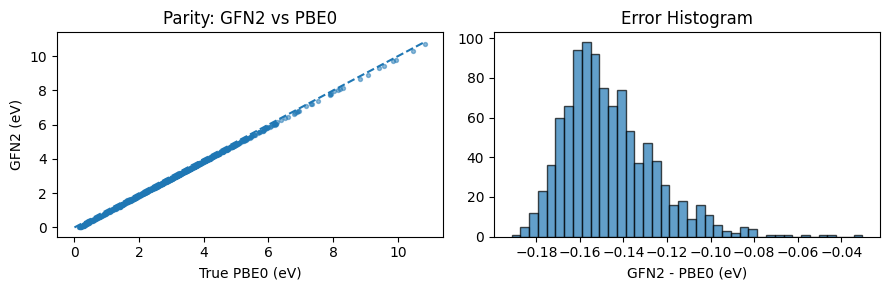

In [27]:
# Plot 1 — GFN2 Parity + Error Histogram (Task A)
import numpy as np, matplotlib.pyplot as plt, os, re

pbe0_true = globals().get("pbe0_true", None)
gfn2_pred = globals().get("gfn2_pred", None)


if pbe0_true is None or gfn2_pred is None:

    pass

if pbe0_true is None or gfn2_pred is None:
    fig, axes = plt.subplots(1,1,figsize=(8,3))
    fig.suptitle("GFN2 Baseline — Data not found")
    axes.text(0.5,0.5,"Run Task A cell first (produces pbe0_true, gfn2_pred arrays)\nOR ensure 'taskA' produced results saved to file.",
              ha="center", va="center")
    axes.axis('off')
    plt.show()
else:
    errors = gfn2_pred - pbe0_true
    fig, axes = plt.subplots(1,2,figsize=(9,3))
    axes[0].scatter(pbe0_true, gfn2_pred, s=8, alpha=0.5)
    mn = min(pbe0_true.min(), gfn2_pred.min()); mx = max(pbe0_true.max(), gfn2_pred.max())
    axes[0].plot([mn,mx],[mn,mx],'--',linewidth=1.5)
    axes[0].set_xlabel("True PBE0 (eV)"); axes[0].set_ylabel("GFN2 (eV)"); axes[0].set_title("Parity: GFN2 vs PBE0")
    axes[1].hist(errors, bins=40, edgecolor='k', alpha=0.7)
    axes[1].set_xlabel("GFN2 - PBE0 (eV)"); axes[1].set_title("Error Histogram")
    plt.tight_layout()
    plt.show()

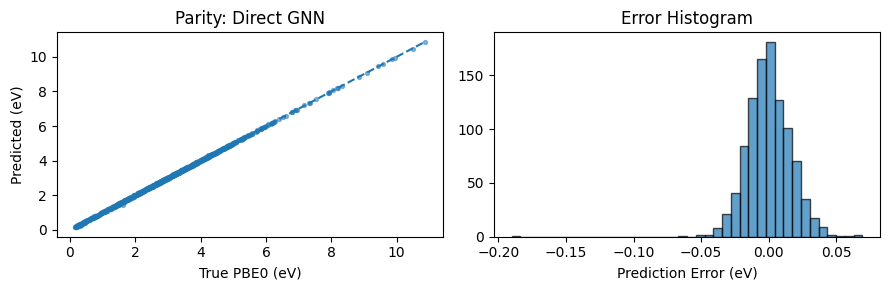

In [28]:
# Plot 2 — Direct GNN parity + error hist (Task B)
import numpy as np, matplotlib.pyplot as plt, os


direct_preds = globals().get("preds", None)
direct_trues = globals().get("trues", None)

if direct_preds is None or direct_trues is None:

    fallback_npy = False
    for a in ["direct_preds.npy","taskB_preds.npy","taskB_test_preds.npy"]:
        if os.path.exists(a):
            direct_preds = np.load(a); fallback_npy = True; break
    for a in ["direct_trues.npy","taskB_trues.npy","taskB_test_trues.npy"]:
        if os.path.exists(a):
            direct_trues = np.load(a); fallback_npy = True; break

if direct_preds is None or direct_trues is None:
    fig, ax = plt.subplots(figsize=(6,3))
    ax.text(0.5,0.5,"Run Task B (Direct GNN) to produce `preds` and `trues` arrays\nor save them as direct_preds.npy/direct_trues.npy.", ha="center", va="center")
    ax.axis('off')
    plt.show()
else:
    errors = direct_preds - direct_trues
    fig, axes = plt.subplots(1,2,figsize=(9,3))
    axes[0].scatter(direct_trues, direct_preds, s=8, alpha=0.5)
    mn = min(direct_trues.min(), direct_preds.min()); mx = max(direct_trues.max(), direct_preds.max())
    axes[0].plot([mn,mx],[mn,mx],'--')
    axes[0].set_xlabel("True PBE0 (eV)"); axes[0].set_ylabel("Predicted (eV)"); axes[0].set_title("Parity: Direct GNN")
    axes[1].hist(errors, bins=40, edgecolor='k', alpha=0.7)
    axes[1].set_xlabel("Prediction Error (eV)"); axes[1].set_title("Error Histogram")
    plt.tight_layout(); plt.show()

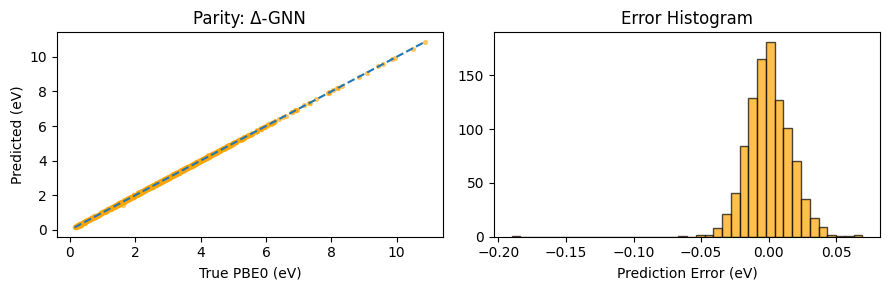

In [29]:
# Plot 3 — Δ-GNN parity + error hist (Task C)
import numpy as np, matplotlib.pyplot as plt, os


delta_preds = globals().get("preds", None)
delta_trues = globals().get("trues", None)

if delta_preds is None or delta_trues is None:
    for a in ["delta_preds.npy","taskC_preds.npy","delta_test_preds.npy"]:
        if os.path.exists(a):
            delta_preds = np.load(a); break
    for a in ["delta_trues.npy","taskC_trues.npy","delta_test_trues.npy"]:
        if os.path.exists(a):
            delta_trues = np.load(a); break

if delta_preds is None or delta_trues is None:
    fig, ax = plt.subplots(figsize=(6,3))
    ax.text(0.5,0.5,"Run Task C (Δ-GNN) to produce `preds` and `trues` arrays\nor save them as delta_preds.npy/delta_trues.npy.", ha="center", va="center")
    ax.axis('off'); plt.show()
else:
    errors = delta_preds - delta_trues
    fig, axes = plt.subplots(1,2,figsize=(9,3))
    axes[0].scatter(delta_trues, delta_preds, s=8, alpha=0.5, color='orange')
    mn = min(delta_trues.min(), delta_preds.min()); mx = max(delta_trues.max(), delta_preds.max())
    axes[0].plot([mn,mx],[mn,mx],'--')
    axes[0].set_xlabel("True PBE0 (eV)"); axes[0].set_ylabel("Predicted (eV)"); axes[0].set_title("Parity: Δ-GNN")
    axes[1].hist(errors, bins=40, edgecolor='k', alpha=0.7, color='orange')
    axes[1].set_xlabel("Prediction Error (eV)"); axes[1].set_title("Error Histogram")
    plt.tight_layout(); plt.show()

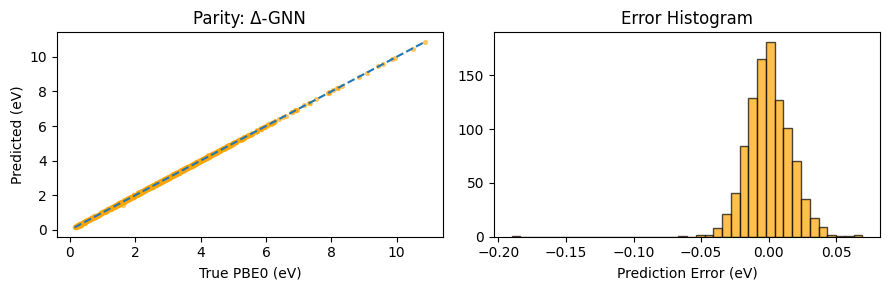

In [30]:
# Plot 3 — Δ-GNN parity + error hist (Task C)
import numpy as np, matplotlib.pyplot as plt, os


delta_preds = globals().get("preds", None)
delta_trues = globals().get("trues", None)


if delta_preds is None or delta_trues is None:
    for a in ["delta_preds.npy","taskC_preds.npy","delta_test_preds.npy"]:
        if os.path.exists(a):
            delta_preds = np.load(a); break
    for a in ["delta_trues.npy","taskC_trues.npy","delta_test_trues.npy"]:
        if os.path.exists(a):
            delta_trues = np.load(a); break

if delta_preds is None or delta_trues is None:
    fig, ax = plt.subplots(figsize=(6,3))
    ax.text(0.5,0.5,"Run Task C (Δ-GNN) to produce `preds` and `trues` arrays\nor save them as delta_preds.npy/delta_trues.npy.", ha="center", va="center")
    ax.axis('off'); plt.show()
else:
    errors = delta_preds - delta_trues
    fig, axes = plt.subplots(1,2,figsize=(9,3))
    axes[0].scatter(delta_trues, delta_preds, s=8, alpha=0.5, color='orange')
    mn = min(delta_trues.min(), delta_preds.min()); mx = max(delta_trues.max(), delta_preds.max())
    axes[0].plot([mn,mx],[mn,mx],'--')
    axes[0].set_xlabel("True PBE0 (eV)"); axes[0].set_ylabel("Predicted (eV)"); axes[0].set_title("Parity: Δ-GNN")
    axes[1].hist(errors, bins=40, edgecolor='k', alpha=0.7, color='orange')
    axes[1].set_xlabel("Prediction Error (eV)"); axes[1].set_title("Error Histogram")
    plt.tight_layout(); plt.show()

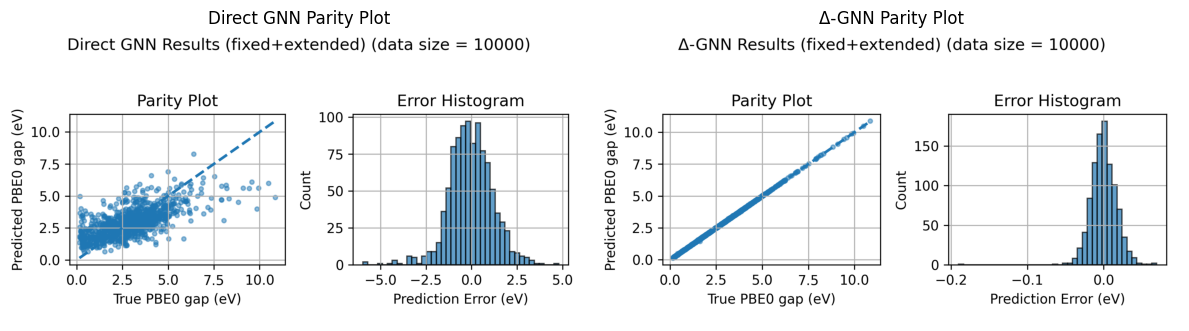

✅ Plot 4 successfully generated using PNG files:
Direct: Direct_GNN_fixed_combined_plot.png
Delta: DeltaGNN_fixed_combined_plot.png


In [36]:
# ==============================
# Plot 4 — Side-by-side Parity Plots
# Direct GNN vs Δ-GNN
# Uses your saved PNG files
# ==============================

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

direct_files = [
    "Direct_GNN_fixed_combined_plot.png",
    "Direct GNN combined_plot.png"
]

delta_files = [
    "DeltaGNN_fixed_combined_plot.png"
]


def pick_existing(files):
    for f in files:
        if os.path.exists(f):
            return f
    return None

direct_img = pick_existing(direct_files)
delta_img = pick_existing(delta_files)

if direct_img is None or delta_img is None:
    print(" Could not find required PNG files.")
    print("Needed:")
    print(" - Direct_GNN_fixed_combined_plot.png or Direct GNN combined_plot.png")
    print(" - DeltaGNN_fixed_combined_plot.png")
else:

    img_direct = mpimg.imread(direct_img)
    img_delta = mpimg.imread(delta_img)


    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(img_direct)
    axes[0].axis("off")
    axes[0].set_title("Direct GNN Parity Plot")

    axes[1].imshow(img_delta)
    axes[1].axis("off")
    axes[1].set_title("Δ-GNN Parity Plot")

    plt.tight_layout()
    plt.show()

    print("✅ Plot 4 successfully generated using PNG files:")
    print("Direct:", direct_img)
    print("Delta:", delta_img)

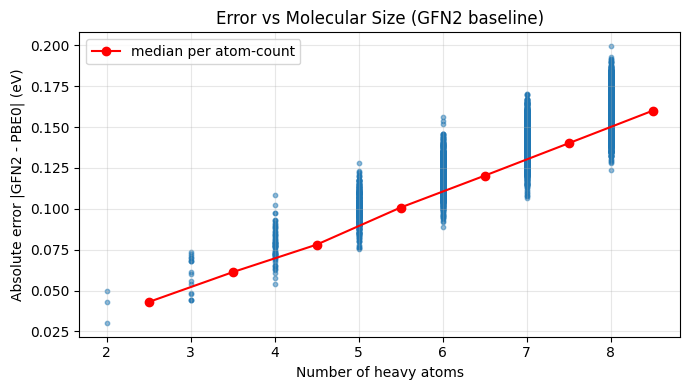

Plotted 10000 graphs. Skipped 0 graphs due to missing data.


In [37]:
# Plot 5: Error vs Number of Heavy Atoms (GFN2 baseline)
import pickle, numpy as np, matplotlib.pyplot as plt, os
from tqdm import tqdm

pkl_path = "graphs.pkl"
if not os.path.exists(pkl_path):
    print("graphs.pkl not found in working directory. Place graphs.pkl here and re-run.")
else:
    with open(pkl_path, "rb") as f:
        graphs = pickle.load(f)

    heavy_counts = []
    abs_errors = []
    missing = 0

    for g in graphs:
        # get gfn2 and pbe0 if present
        try:
            gfn2 = float(g.gfn2_gap.item()) if hasattr(g, "gfn2_gap") else None
            pbe0 = float(g.pbe0_gap.item()) if hasattr(g, "pbe0_gap") else None
        except Exception:
            missing += 1
            continue
        if gfn2 is None or pbe0 is None or (not np.isfinite(gfn2)) or (not np.isfinite(pbe0)):
            missing += 1
            continue

        # get heavy atom count
        if hasattr(g, "num_heavy_atoms"):
            ha = int(g.num_heavy_atoms)
        else:
            # compute from node atomic numbers (assume g.x is [N,1] atomic numbers)
            try:
                an = g.x.numpy().squeeze()
                ha = int((an != 1).sum())
            except Exception:
                # fallback: unknown
                ha = None

        if ha is None:
            missing += 1
            continue

        heavy_counts.append(ha)
        abs_errors.append(abs(gfn2 - pbe0))

    heavy_counts = np.array(heavy_counts)
    abs_errors = np.array(abs_errors)

    if heavy_counts.size == 0:
        print("No usable graphs found to compute GFN2 errors.")
    else:
        plt.figure(figsize=(7,4))
        plt.scatter(heavy_counts, abs_errors, s=10, alpha=0.5)
        # trendline (median error per heavy-atom bin)
        bins = np.arange(0, heavy_counts.max()+2)
        medians = []
        centers = []
        for i in range(len(bins)-1):
            mask = (heavy_counts >= bins[i]) & (heavy_counts < bins[i+1])
            if mask.sum() > 0:
                medians.append(np.median(abs_errors[mask]))
                centers.append((bins[i] + bins[i+1])/2.0)
        if len(centers) > 0:
            plt.plot(centers, medians, marker='o', linestyle='-', color='red', label='median per atom-count')
            plt.legend()
        plt.xlabel("Number of heavy atoms")
        plt.ylabel("Absolute error |GFN2 - PBE0| (eV)")
        plt.title("Error vs Molecular Size (GFN2 baseline)")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        print(f"Plotted {len(abs_errors)} graphs. Skipped {missing} graphs due to missing data.")

GFN2: taskA_results.txt -> 0.1464
Direct: taskB_results.txt -> 0.9256
Delta: taskC_results.txt -> 0.0127


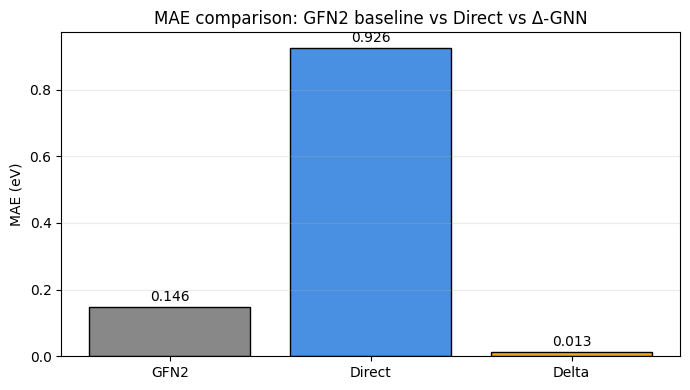

In [38]:
# Plot 6: MAE comparison (GFN2, Direct, Δ)
import re, os, matplotlib.pyplot as plt, numpy as np

def parse_mae_from_file(path):
    if not os.path.exists(path):
        return None
    txt = open(path, "r", encoding="utf-8", errors="ignore").read()
    # try multiple likely patterns
    patterns = [
        r"GFN2 Baseline MAE:\s*([0-9.+-eE]+)",
        r"GFN2 Baseline MAE\s*=\s*([0-9.+-eE]+)",
        r"TEST MAE\s*=\s*([0-9.+-eE]+)",
        r"TEST MAE:\s*([0-9.+-eE]+)",
        r"Test MAE\s*=\s*([0-9.+-eE]+)",
        r"Test MAE:\s*([0-9.+-eE]+)",
        r"Test MAE\s*=\s*([0-9.+-eE]+)\s*eV",
        r"MAE:\s*([0-9.+-eE]+)\s*eV"
    ]
    for p in patterns:
        m = re.search(p, txt)
        if m:
            try:
                return float(m.group(1))
            except:
                pass
    # fallback: look for a single number after "MAE"
    m2 = re.search(r"MAE[^0-9\n]*([0-9]+(?:\.[0-9]+)?)", txt)
    if m2:
        try:
            return float(m2.group(1))
        except:
            pass
    return None

files = {
    "GFN2": "taskA_results.txt",
    "Direct": "taskB_results.txt",
    "Delta": "taskC_results.txt"
}

maes = {}
for k,f in files.items():
    val = parse_mae_from_file(f)
    maes[k] = val
    print(f"{k}: {f} -> {val}")

# Prepare bar plot
labels = []
values = []
for k in ["GFN2","Direct","Delta"]:
    if maes.get(k) is not None:
        labels.append(k)
        values.append(maes[k])


plt.figure(figsize=(7,4))
bars = plt.bar(labels, values, color=["#888888","#4A90E2","#F5A623"], edgecolor='k')
plt.ylabel("MAE (eV)")
plt.title("MAE comparison: GFN2 baseline vs Direct vs Δ-GNN")
plt.grid(axis="y", alpha=0.25)
for b, v in zip(bars, values):
  plt.text(b.get_x() + b.get_width()/2, v + 0.01*max(0.001, max(values)), f"{v:.3f}", ha="center", va="bottom")
  plt.tight_layout()
  plt.show()

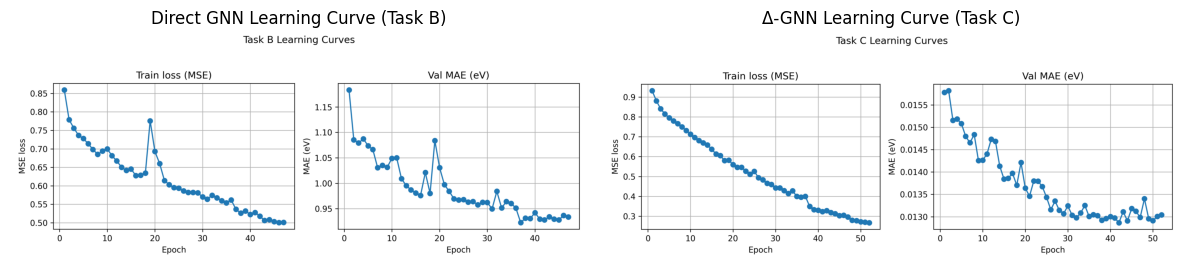

In [39]:
# Plot 7: Learning curves side-by-side (Task B & Task C PNGs)
import matplotlib.pyplot as plt, matplotlib.image as mpimg, os

b_png = "taskB_learning_curve.png"
c_png = "taskC_learning_curve.png"

missing = []
if not os.path.exists(b_png):
    missing.append(b_png)
if not os.path.exists(c_png):
    missing.append(c_png)

if missing:
    print("Missing learning-curve image(s):", missing)
    print("Expected files:", b_png, c_png)
    print("If you saved learning-curve plots under different names, rename or copy them accordingly.")
else:
    imgB = mpimg.imread(b_png)
    imgC = mpimg.imread(c_png)

    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[0].imshow(imgB); axes[0].axis("off"); axes[0].set_title("Direct GNN Learning Curve (Task B)")
    axes[1].imshow(imgC); axes[1].axis("off"); axes[1].set_title("Δ-GNN Learning Curve (Task C)")
    plt.tight_layout()
    plt.show()